In [1]:
seed = 123

In [2]:
# import helper functions
from shutil import copyfile
copyfile(
    src = "/kaggle/input/bdc-p53/p53_helper_functions.py", 
    dst = "/kaggle/working/p53_helpers.py"
)
from p53_helpers import *

# load dataset (no NAs)
X, Y = load_p53_ds()
# sratified 80/20 split
X_train, X_test, Y_train, Y_test = split_p53(X, Y)

Using TensorFlow backend.



Import completed after 3.7 sec

CLASS RATIOS
Training set active classes:   121/24927 (0.485 %)
Test set active classes:       30/6232 (0.481 %)

MATRIX DIMENSIONS
TRAINING SET
. Features:   (24927, 5408)
. Classes:    (24927,)
TEST SET
. Features:   (6232, 5408)
. Classes:    (6232,)


In [3]:
# slightly downsample majority class to speed up iterations
DS = RandomUnderSampler(sampling_strategy=0.01)
X_train, Y_train = DS.fit_resample(X_train, Y_train)

print(X_train.shape)
print(Y_train.mean())

(12221, 5408)
0.009900990099009901


In [4]:
CV = 4

# initialize df
results = pd.DataFrame(
    index=np.arange(1000), columns=[
    "remove_corr_n", "scaler", "fs_model", "fs_m", "pca_n", "tot_n_features", "max_depth", "n_estimators",
    "train_mcc", "val_mcc", "train_balanced_acc", "val_balanced_acc"]
)

i = 0  # counter

for n_remove in [0, 50, 100, 500, 1000]:
    
    if n_remove:
        X_t = RemoveCorrelatedFeatures(n_remove=n_remove).fit_transform(X_train)

    else:
        X_t = X_train
    
    for scaler in [RobustScaler(), StandardScaler()]:

        if scaler != "no_scaling":
            X_t_ = scaler.fit_transform(X_t)
            scaler_name = scaler.__class__.__name__
        else:
            scaler_name = scaler

        # model-based selection
        for model_name, model in [
            ("ExtraTreesClf_10", ExtraTreesClassifier(n_estimators=10, random_state=seed)),
            ("ExtraTreesClf_50", ExtraTreesClassifier(n_estimators=50, random_state=seed)),
            ("ExtraTreesClf_100", ExtraTreesClassifier(n_estimators=50, random_state=seed))
        ]:

            # fit the model
            model.fit(X_t_, Y_train)

            # select m best features according to model
            for m in [100]:

                sel = SelectFromModel(model, prefit=True, threshold=-np.inf, max_features=m)
                model_sel = set(sel.get_support(indices=True))

                X_train_selection = np.array(X_t_)[:, list(model_sel)]

                # Fit different RFCs
                for max_depth in [10, None]:

                    for n_estimators in [750, 1000]:

                        pca_n = 0
                        out = [n_remove, scaler_name, model_name, m, pca_n, X_train_selection.shape[-1], str(max_depth), n_estimators]

                        print("=" * 80)
                        print(" | ".join(str(o).ljust(10) for o in out), f" |  (i={i})")
                        print("=" * 80)

                        out.extend(
                            cv(model=RandomForestClassifier(random_state=seed, class_weight="balanced", max_depth=max_depth, n_estimators=n_estimators),
                               x=X_train_selection,
                               y=Y_train,
                               cv=CV,
                               n_jobs=-1
                              )
                        )

                        # store results
                        for col, value in zip(results.columns, out):
                            results[col][i] = value

                        i += 1

0          | RobustScaler | ExtraTreesClf_10 | 100        | 0          | 100        | 10         | 750         |  (i=0)
test_balanced_acc              0.70 (± 0.02)       [0.69, 0.68, 0.7, 0.73]
test_mcc                       0.54 (± 0.03)       [0.52, 0.52, 0.53, 0.6]
--------------------------------------------------------------------------------
Training MCC:                  0.96 (± 0.01)       [0.96, 0.95, 0.97, 0.96]

0          | RobustScaler | ExtraTreesClf_10 | 100        | 0          | 100        | 10         | 1000        |  (i=1)
test_balanced_acc              0.70 (± 0.02)       [0.69, 0.68, 0.7, 0.73]
test_mcc                       0.54 (± 0.03)       [0.52, 0.52, 0.53, 0.6]
--------------------------------------------------------------------------------
Training MCC:                  0.96 (± 0.01)       [0.97, 0.94, 0.97, 0.97]

0          | RobustScaler | ExtraTreesClf_10 | 100        | 0          | 100        | None       | 750         |  (i=2)
test_balanced_acc       

In [5]:
results = results.dropna(axis=0)
results.sort_values("val_mcc", ascending=False)

,remove_corr_n,scaler,fs_model,fs_m,pca_n,tot_n_features,max_depth,n_estimators,train_mcc,val_mcc,train_balanced_acc,val_balanced_acc
60,100,StandardScaler,ExtraTreesClf_10,100,0,100,10,750,0.961575,0.587076,0.999587,0.722498
48,100,RobustScaler,ExtraTreesClf_10,100,0,100,10,750,0.960494,0.587076,0.999573,0.722498
61,100,StandardScaler,ExtraTreesClf_10,100,0,100,10,1000,0.958641,0.585822,0.999545,0.726582
49,100,RobustScaler,ExtraTreesClf_10,100,0,100,10,1000,0.958641,0.585822,0.999545,0.726582
85,500,StandardScaler,ExtraTreesClf_10,100,0,100,10,1000,0.961237,0.570983,0.999587,0.714258
...,...,...,...,...,...,...,...,...,...,...,...,...
74,500,RobustScaler,ExtraTreesClf_10,100,0,100,None,750,1,0.485561,1,0.640168
113,1000,StandardScaler,ExtraTreesClf_50,100,0,100,10,1000,0.894767,0.481744,0.998678,0.713329
117,1000,StandardScaler,ExtraTreesClf_100,100,0,100,10,1000,0.894767,0.481744,0.998678,0.713329
105,1000,RobustScaler,ExtraTreesClf_100,100,0,100,10,1000,0.894767,0.479751,0.998678,0.713287


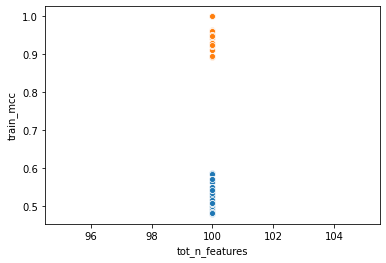

In [6]:
sns.scatterplot(x="tot_n_features", y="val_mcc", data=results);
sns.scatterplot(x="tot_n_features", y="train_mcc", data=results);

In [7]:
results.to_csv("/kaggle/working/results_removecorr_incl.csv")